## Imports

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20, 10)

## Load data

In [2]:
data_root = os.path.join('..', 'data', 'main')

In [3]:
data = pd.read_csv(os.path.join(data_root, "fact_train_test.csv"), sep=";", decimal=",", encoding="windows-1251")
data["period"] = data["period"].astype("datetime64[ns]")

In [4]:
data.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1


## Preprocess data

In [5]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = os.path.join(data_root, "client_mapping.csv")
    freight_mapping_file = os.path.join(data_root, "freight_mapping.csv")
    station_mapping_file = os.path.join(data_root, "station_mapping.csv")

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df

In [6]:
extended_data = add_master_data_mappings(data)

In [7]:
extended_data.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39


In [8]:
extended_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   period                     datetime64[ns]
 1   rps                        int64         
 2   podrod                     int64         
 3   filial                     int64         
 4   client_sap_id              int64         
 5   freight_id                 int64         
 6   sender_station_id          int64         
 7   recipient_station_id       int64         
 8   sender_organisation_id     int64         
 9   real_weight                float64       
 10  real_wagon_count           int64         
 11  holding_name               float64       
 12  freight_group_name         int64         
 13  sender_department_name     int64         
 14  sender_railway_name        int64         
 15  recipient_department_name  int64         
 16  recipient_railway_name     int64    

In [9]:
def fix_types(df: pd.DataFrame):
    col_type_dict = {
        'rps': 'int8',
        'podrod': 'int8',
        'filial': 'int8',
        'client_sap_id': 'int16',
        'freight_id': 'int16',
        'sender_station_id': 'int32',
        'recipient_station_id': 'int32',
        'sender_organisation_id': 'int32',
        'real_weight': 'float64',
        'real_wagon_count': 'int32',
        'holding_name': 'int16',
        'freight_group_name': 'int8',
        'sender_department_name': 'int8',
        'sender_railway_name': 'int8',     
        'recipient_department_name': 'int8',     
        'recipient_railway_name': 'int8', 
    }

    for col_name, col_type in col_type_dict.items():
        df[col_name] = df[col_name].astype(col_type)

    return df

In [10]:
extended_data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423.0,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423.0,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423.0,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423.0,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423.0,30,153,12,94,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1,2226.0,22,73,14,143,35
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1,2226.0,22,73,14,79,10
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1,2226.0,22,73,14,104,10
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3,2226.0,22,73,14,143,35


In [11]:
extended_data.loc[extended_data['holding_name'].isna(), 'holding_name'] = -1 
extended_data = fix_types(extended_data)

In [12]:
extended_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559232 entries, 0 to 3559231
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   period                     datetime64[ns]
 1   rps                        int8          
 2   podrod                     int8          
 3   filial                     int8          
 4   client_sap_id              int16         
 5   freight_id                 int16         
 6   sender_station_id          int32         
 7   recipient_station_id       int32         
 8   sender_organisation_id     int32         
 9   real_weight                float64       
 10  real_wagon_count           int32         
 11  holding_name               int16         
 12  freight_group_name         int8          
 13  sender_department_name     int8          
 14  sender_railway_name        int8          
 15  recipient_department_name  int8          
 16  recipient_railway_name     int8     

In [13]:
extended_data.to_csv(os.path.join('..', 'data', 'train', 'extended_dataset.csv'), index=False)

## Data description

In [14]:
data_desc = pd.read_excel(os.path.join(data_root, 'Описание данных для хакатона - прогноз ЖД перевозок.xlsx')).iloc[1:]
data_desc = pd.DataFrame(data=data_desc.iloc[1:].values, columns=data_desc.iloc[0].values)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)

In [15]:
data_desc

,Поле,Тип данных,Описание
0,period,date,"Месяц предъявления отправки к перевозке в формате ""YYYY-MM-DD"""
1,rps,integer,Род Подвижного Состава
2,podrod,integer,Подрод Подвижного Состава
3,filial,integer,"Филиал ""ПГК"""
4,client_sap_id,integer,Код отправителя
5,freight_id,integer,Код груза
6,sender_station_id,integer,Код пункта отправления
7,recipient_station_id,integer,Код пункта назначения
8,sender_organisation_id,integer,Код погрузочно-выгрузочного пункта
9,real_weight,float,"Суммарный вес фактически перевезенного груза, тонн"


In [16]:
data.describe()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
count,3559232,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06,3.559232e+06
mean,2020-01-01 04:50:29.038176256,5.979641e-01,3.338106e+00,1.148843e+00,3.865685e+02,1.712424e+03,2.628122e+04,2.598168e+04,1.499681e+04,1.349654e+03,1.988760e+01
min,2012-07-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00,0.000000e+00
25%,2018-06-01 00:00:00,0.000000e+00,2.000000e+00,1.000000e+00,-1.000000e+00,1.059000e+03,1.427200e+04,1.373100e+04,7.856000e+03,6.500000e+01,1.000000e+00
50%,2020-01-01 00:00:00,1.000000e+00,5.000000e+00,1.000000e+00,1.080000e+02,1.622000e+03,3.051900e+04,3.079000e+04,1.202600e+04,1.300000e+02,2.000000e+00
75%,2021-08-01 00:00:00,1.000000e+00,5.000000e+00,1.000000e+00,6.010000e+02,2.219000e+03,3.519600e+04,3.519600e+04,2.201100e+04,3.990000e+02,6.000000e+00
max,2023-03-01 00:00:00,1.000000e+00,9.000000e+00,2.000000e+00,2.417000e+03,5.086000e+03,3.912300e+04,3.912300e+04,3.453600e+04,8.204350e+05,1.180900e+04
std,NaN,4.903092e-01,1.964952e+00,5.305394e-01,5.398728e+02,1.029591e+03,1.110980e+04,1.146103e+04,8.048006e+03,9.062866e+03,1.301516e+02


In [17]:
data.shape

(3559232, 11)

**Особенности данных**

`rps` - имеет 2 значения (большие и малые вагоны)

`podrod` - имеет 7 различных значений

`filial` - имеет 2 уникальных значения

`real_weight` - имеет выбросы (от -6 до -1)

<Axes: xlabel='rps', ylabel='count'>

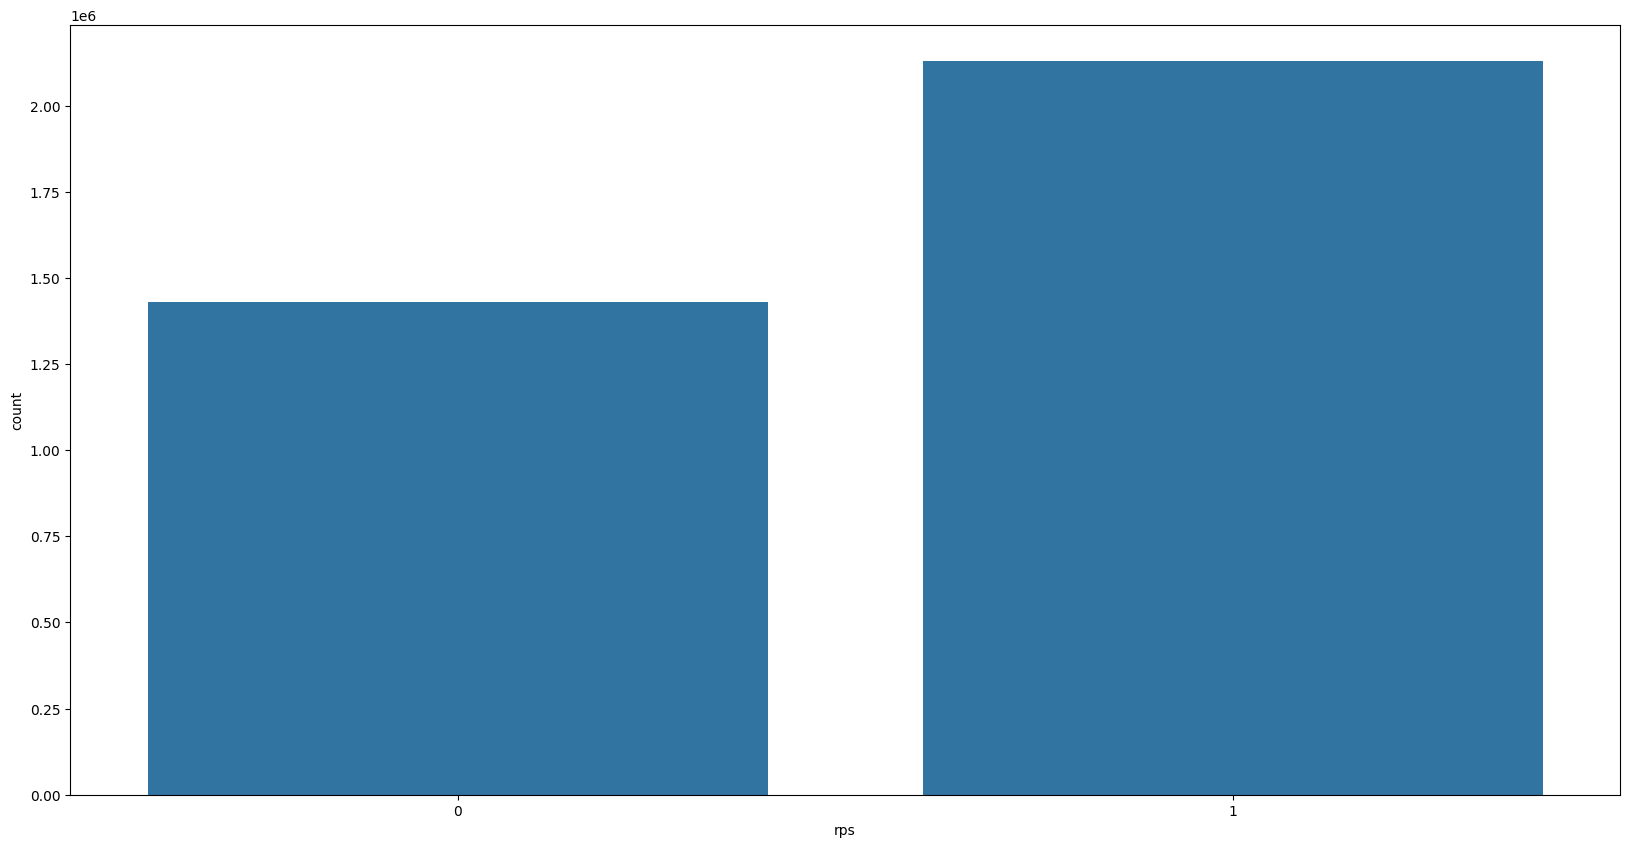

In [18]:
sns.barplot(data.rps.value_counts())

<Axes: xlabel='podrod', ylabel='count'>

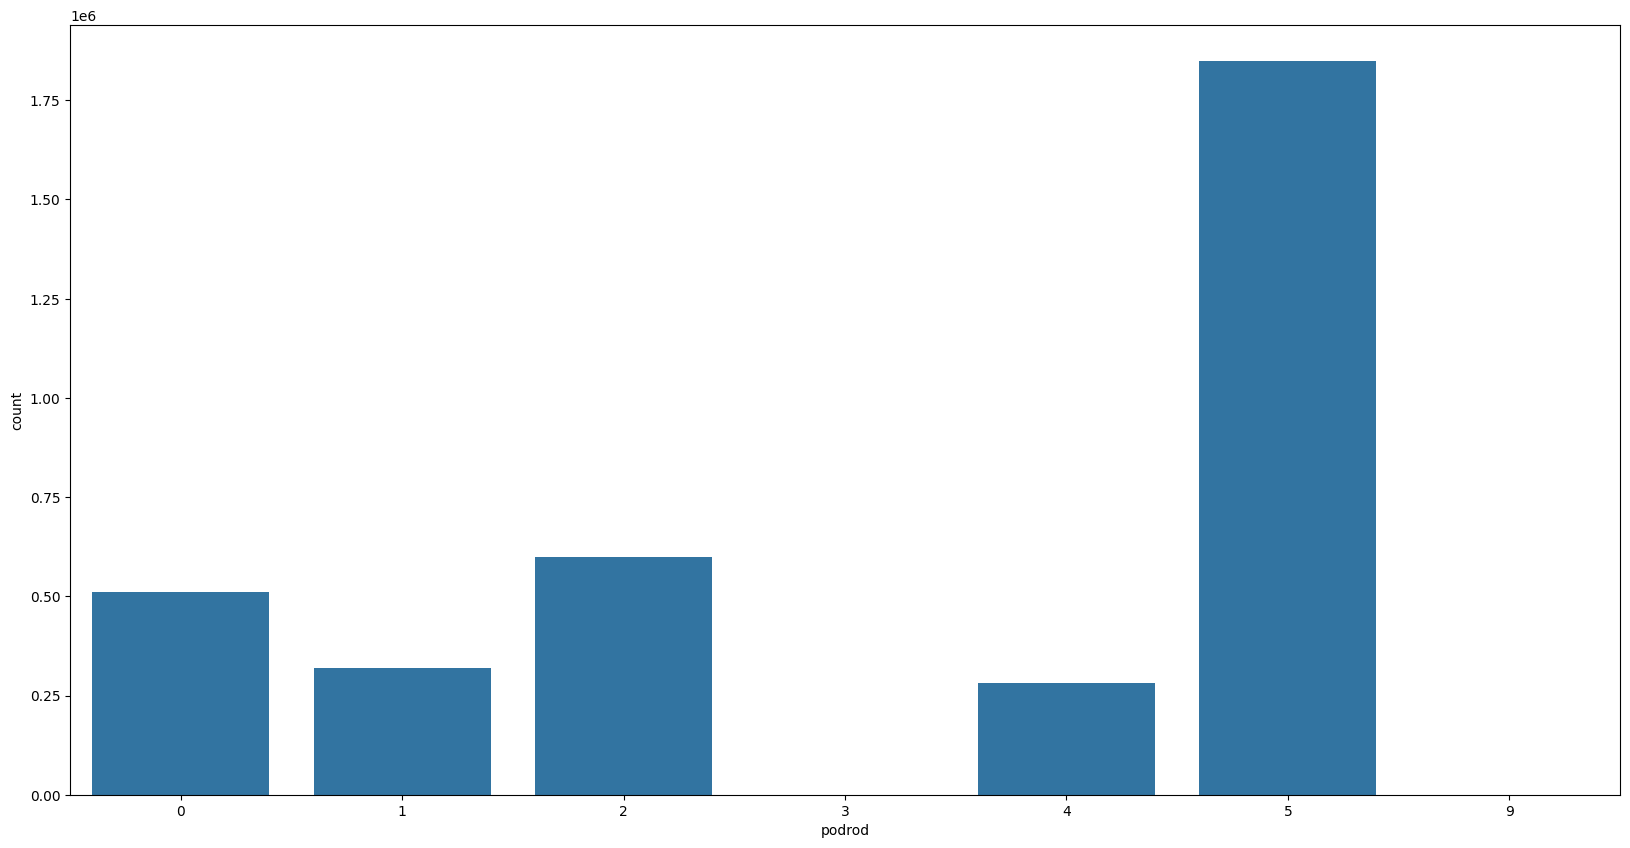

In [19]:
sns.barplot(data.podrod.value_counts())

In [20]:
target_granularity = [
    "period",
    "rps",
    "recipient_railway_name",
    "sender_railway_name",
    
    # "holding_name",
    # "sender_department_name",
    # "recipient_department_name",
]

In [21]:
shorten_data = extended_data[target_granularity + ['real_wagon_count']]

In [22]:
shorten_data

,period,rps,recipient_railway_name,sender_railway_name,real_wagon_count
0,2012-07-01,1,4,12,1
1,2012-10-01,1,23,12,3
2,2014-03-01,0,11,12,1
3,2014-03-01,0,11,12,1
4,2014-03-01,0,39,12,1
...,...,...,...,...,...
3559227,2023-03-01,1,35,14,1
3559228,2023-03-01,1,10,14,1
3559229,2023-03-01,1,10,14,1
3559230,2023-03-01,1,35,14,3


In [23]:
y_counts = list()
popularity_wagon_count_dict = dict()

for _, item in shorten_data.groupby(target_granularity[1:]):
    item = item.groupby('period').sum()
    
    x = item.index    
    y = item.real_wagon_count
    
    y_counts.append(y.shape[0])
    popularity_wagon_count_dict[y.shape[0]] = popularity_wagon_count_dict.get(y.shape[0], 0) + y.sum()

Text(0, 0.5, 'Кол-во связок с таким кол-вом заказов')

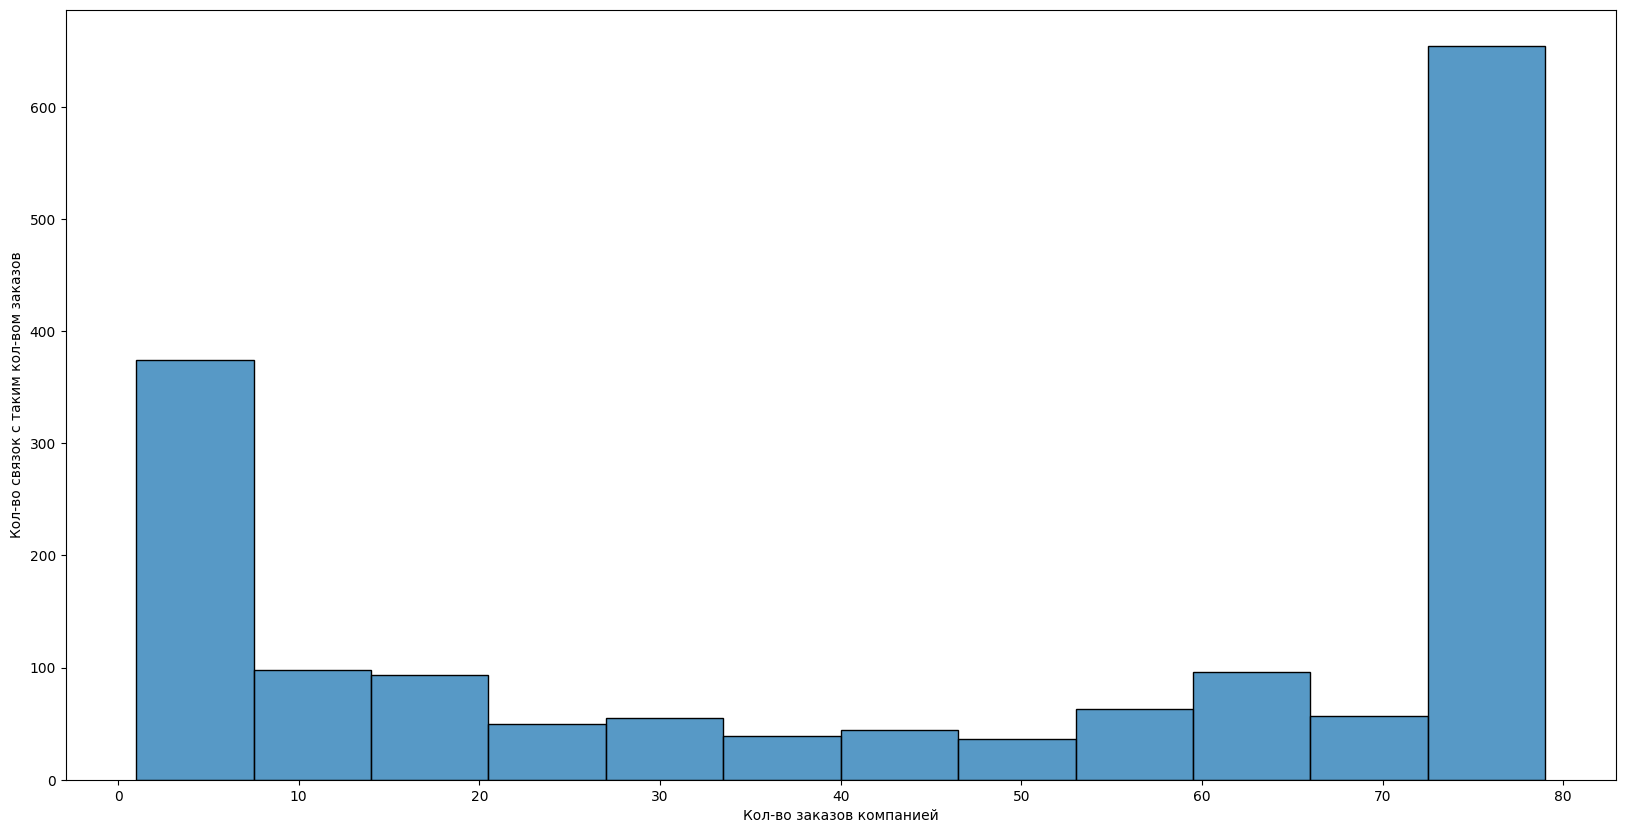

In [24]:
sns.histplot(y_counts)
# plt.title('')
plt.xlabel('Кол-во заказов компанией')
plt.ylabel('Кол-во связок с таким кол-вом заказов')

In [25]:
np.unique(np.array(y_counts), return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([131,  80,  40,  53,  28,  19,  23,  14,  18,  20,  14,  15,  17,
         19,  14,  12,   5,  14,  14,  15,  14,   5,   6,   7,  12,   6,
          2,   9,   7,  14,   7,   6,  10,  10,   5,   3,   9,   8,   4,
          4,   7,   8,   8,   3,   9,   5,   4,  12,   3,   5,   7,   5,
          4,  10,   9,   8,   6,  10,  16,  12,  21,  24,  23,   9,   7,
         10,   5,   5,   8,   8,  11,  10,  20,  21, 231, 376,   3,   1,
          2]))

Text(0, 0.5, 'Кол-во связок с таким кол-вом заказов')

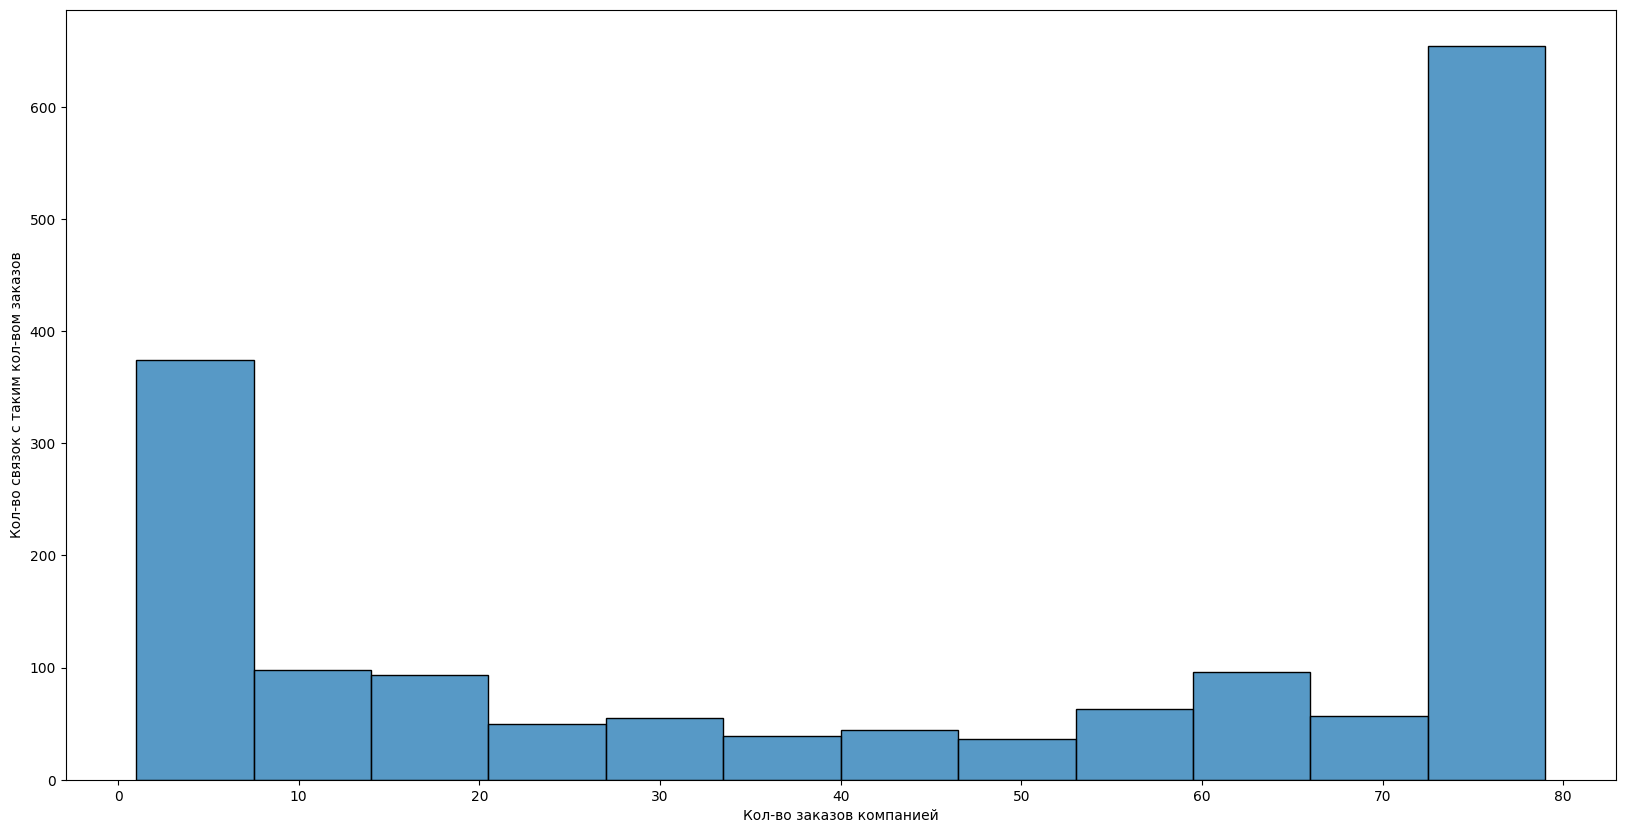

In [26]:
sns.histplot(y_counts)
# plt.title('')
plt.xlabel('Кол-во заказов компанией')
plt.ylabel('Кол-во связок с таким кол-вом заказов')

In [27]:
import numpy as np

In [28]:
np.unique(np.array(y_counts), return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([131,  80,  40,  53,  28,  19,  23,  14,  18,  20,  14,  15,  17,
         19,  14,  12,   5,  14,  14,  15,  14,   5,   6,   7,  12,   6,
          2,   9,   7,  14,   7,   6,  10,  10,   5,   3,   9,   8,   4,
          4,   7,   8,   8,   3,   9,   5,   4,  12,   3,   5,   7,   5,
          4,  10,   9,   8,   6,  10,  16,  12,  21,  24,  23,   9,   7,
         10,   5,   5,   8,   8,  11,  10,  20,  21, 231, 376,   3,   1,
          2]))

In [29]:
extended_data['recipient_railway_name'].value_counts().shape

(39,)

Text(0, 0.5, 'Кол-во связок с таким кол-вом заказов')

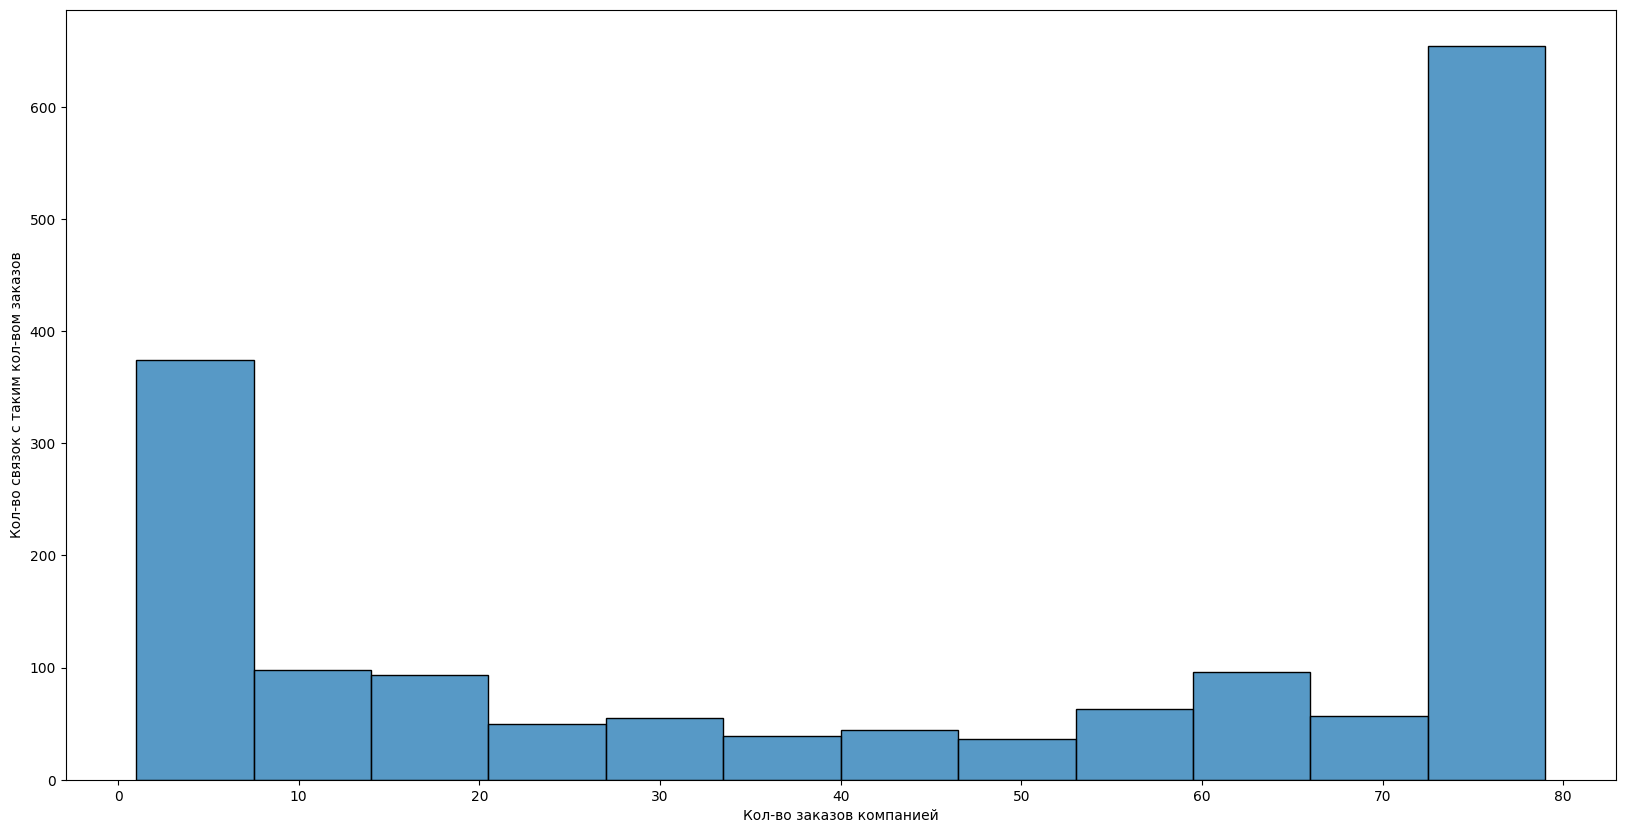

In [31]:
sns.histplot(y_counts)
# plt.title('')
plt.xlabel('Кол-во заказов компанией')
plt.ylabel('Кол-во связок с таким кол-вом заказов')

Text(0, 0.5, 'Сумма вагонов в этих заказах')

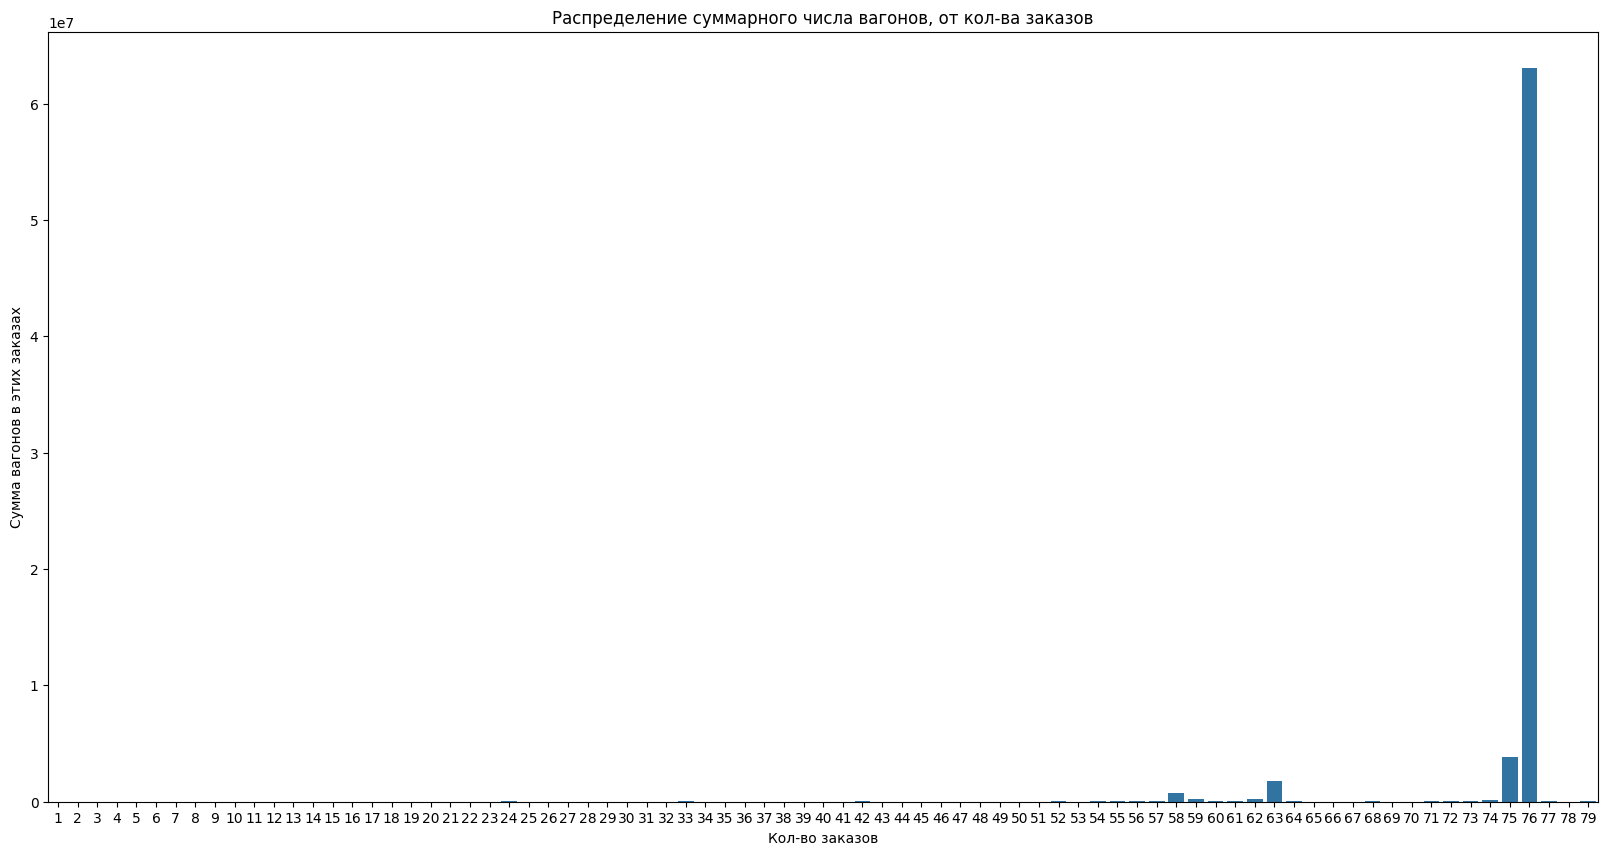

In [32]:
x_data = list()
y_data = list()

for key, value in popularity_wagon_count_dict.items():
    x_data.append(key)
    y_data.append(value)

sns.barplot(x=x_data, y=y_data)
plt.title('Распределение суммарного числа вагонов, от кол-ва заказов')
plt.xlabel('Кол-во заказов')
plt.ylabel('Сумма вагонов в этих заказах')

## Baseline Error Analysis

In [33]:
data_root = os.path.join('..', 'data', 'train')

In [34]:
def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    data_root = os.path.join('..', 'data', 'main')
    
    # = Пути к справочникам - откорректировать если в реальной системе будут лежать по другому адресу =
    client_mapping_file = os.path.join(data_root, "client_mapping.csv")
    freight_mapping_file = os.path.join(data_root, "freight_mapping.csv")
    station_mapping_file = os.path.join(data_root, "station_mapping.csv")

    # Клиент - холдинг
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")

    # Груз
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")

    # Станции
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    fact = add_master_data_mappings(fact)
    forecast = add_master_data_mappings(forecast)
    
    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    weighted_summary = summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    
    score = (
        weighted_summary
    ).sum()

    return score, weighted_summary, compare_data


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)



In [35]:
# Факт на задание
fact = pd.read_csv(os.path.join(data_root, "train_data.csv"))
fact["period"] = fact["period"].astype("datetime64[ns]")
# fact - уже обрезанная выборка

# Пример прогноза - наивный, копия последнего факта
result = []
last_known_fact_month = fact["period"].max()
test_periods = pd.date_range(start=last_known_fact_month, periods=6, freq='MS', inclusive='right')


for period in test_periods:
    print(period)
    month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True)
    month_forecast["period"] = period
    result.append(month_forecast)
result = pd.concat(result).reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
result.to_csv(os.path.join(data_root, "forecast_example.csv"), index=False, sep=";", decimal=",", encoding="windows-1251")


2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00


In [36]:
fact.head()

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423,21,-103,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423,21,-103,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423,30,-103,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423,30,-103,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423,30,-103,12,94,39


In [37]:
# = Примеры файлов для проверки =
validation_file = os.path.join(data_root, "test_data.csv")
forecast_file = os.path.join(data_root, "forecast_example.csv")

# Валидационный датасет
fact = pd.read_csv(validation_file)
print("Валидационный датасет:", fact.shape)
# Прогноз
forecast = pd.read_csv(forecast_file, sep=";", decimal=",", encoding="windows-1251")
print("Прогноз:", forecast.shape)

fact = fact[['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id', 'sender_station_id', 'recipient_station_id', 'sender_organisation_id', 'real_weight', 'real_wagon_count']]
forecast = forecast[['period', 'rps', 'podrod', 'filial', 'client_sap_id', 'freight_id', 'sender_station_id', 'recipient_station_id', 'sender_organisation_id', 'forecast_weight', 'forecast_wagon_count']]


# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public[0]}")
print(f"Private score: {score_private[0]}")

Валидационный датасет: (218828, 17)
Прогноз: (229550, 17)
Public score: 0.639683424247945
Private score: 0.6364087430299136


In [38]:
compare_table = score_private[2]

In [39]:
compare_table

,period,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count,forecast_wagon_count,ABS_ERR,MAX
0,2022-11-01,0,24.0,124,4,2,4,2,4
1,2022-11-01,0,24.0,124,73,3,0,3,3
2,2022-11-01,0,24.0,124,142,3,6,3,6
3,2022-11-01,0,24.0,124,143,1,3,2,3
4,2022-11-01,0,27.0,2,15,4,0,4,4
...,...,...,...,...,...,...,...,...,...
61645,2023-03-01,1,2243.0,146,8,0,1,1,1
61646,2023-03-01,1,2243.0,146,9,0,3,3,3
61647,2023-03-01,1,2243.0,146,18,0,4,4,4
61648,2023-03-01,1,2243.0,146,23,0,6,6,6


In [40]:
compare_table.describe()

,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count,forecast_wagon_count,ABS_ERR,MAX
count,61650.000000,61650.000000,61650.000000,61650.000000,61650.000000,61650.000000,61650.000000,61650.000000
mean,0.477097,1142.229311,82.434923,85.699400,60.922595,63.629684,28.080065,76.316172
std,0.499479,601.725310,49.049357,50.723628,571.370404,590.842639,149.087785,627.761305
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,598.000000,27.000000,37.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,1196.000000,86.000000,93.000000,2.000000,2.000000,2.000000,4.000000
75%,1.000000,1575.000000,123.000000,133.000000,9.000000,10.000000,9.000000,16.000000
max,1.000000,2246.000000,171.000000,171.000000,28455.000000,31409.000000,8464.000000,31409.000000


In [41]:
compare_table['error_part'] = compare_table['ABS_ERR'] / compare_table['MAX']

In [42]:
compare_table[compare_table['ABS_ERR'].max() == compare_table['ABS_ERR']]

,period,rps,holding_name,sender_department_name,recipient_department_name,real_wagon_count,forecast_wagon_count,ABS_ERR,MAX,error_part
31729,2023-02-01,1,519.0,79,79,22945,31409,8464,31409,0.269477


In [44]:
def find_value(data, rps, holding_name, sender_department_name, recipient_department_name):
    return data[(data['rps'] == rps) & (data['holding_name'] == holding_name) & (data['sender_department_name'] == sender_department_name) & (data['recipient_department_name'] == recipient_department_name)]

In [45]:
accuracy_granularity = [
    "period",
    "rps",
    "holding_name",
    "sender_department_name",
    "recipient_department_name",
]

extended_fact = add_master_data_mappings(fact)
extended_forecast = add_master_data_mappings(forecast)

grouped_fact = extended_fact.groupby(accuracy_granularity, as_index=False).sum()
grouped_forecast = extended_forecast.groupby(accuracy_granularity, as_index=False).sum()

In [46]:
find_value(grouped_fact, 1, 519, 79, 79)

,period,rps,holding_name,sender_department_name,recipient_department_name,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,freight_group_name,sender_railway_name,recipient_railway_name
5541,2022-11-01,1,519.0,79,79,826,240,383220,172690,6442012,6447779,4486211,1893446.0,27044,2697,1800,1800
14807,2022-12-01,1,519.0,79,79,827,249,383220,170814,6442107,6445979,4599739,1722501.0,24576,2446,1800,1800
23339,2023-01-01,1,519.0,79,79,815,248,378962,159189,6372040,6375145,4586011,1762909.0,25208,2115,1780,1780
31729,2023-02-01,1,519.0,79,79,819,244,381091,165539,6407777,6409679,4548630,1615116.0,22945,2279,1790,1790
40851,2023-03-01,1,519.0,79,79,868,257,402381,180767,6765784,6769406,4874748,1999009.0,28455,2654,1890,1890


In [47]:
find_value(grouped_forecast, 1, 519, 79, 79)

,period,rps,holding_name,sender_department_name,recipient_department_name,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,forecast_weight,forecast_wagon_count,freight_group_name,sender_railway_name,recipient_railway_name
5632,2022-11-01,1,519.0,79,79,809,236,19008,173027,6299136,6304189,4420441,2206326.0,31409,2760,1760,1760
15043,2022-12-01,1,519.0,79,79,809,236,19008,173027,6299136,6304189,4420441,2206326.0,31409,2760,1760,1760
24454,2023-01-01,1,519.0,79,79,809,236,19008,173027,6299136,6304189,4420441,2206326.0,31409,2760,1760,1760
33865,2023-02-01,1,519.0,79,79,809,236,19008,173027,6299136,6304189,4420441,2206326.0,31409,2760,1760,1760
43276,2023-03-01,1,519.0,79,79,809,236,19008,173027,6299136,6304189,4420441,2206326.0,31409,2760,1760,1760


In [48]:
grouped_extended = extended_data.groupby(accuracy_granularity, as_index=False).sum()

find_value(grouped_extended, 1, 519, 79, 79)

,period,rps,holding_name,sender_department_name,recipient_department_name,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,freight_group_name,sender_railway_name,recipient_railway_name
998,2016-12-01,1,519,79,79,25,5,540,5411,179087,179535,18308,6901.0,102,99,50,50
9790,2017-01-01,1,519,79,79,635,165,14256,145237,4725487,4728481,558004,1967709.0,28589,2618,1320,1320
22226,2017-02-01,1,519,79,79,767,205,17280,168265,5728292,5731776,1174581,1863547.0,27038,2836,1600,1600
36024,2017-03-01,1,519,79,79,618,168,13932,142693,4618058,4621611,1058012,2113670.0,30712,2584,1290,1290
50421,2017-04-01,1,519,79,79,706,199,15984,163019,5297843,5304221,1185641,2044949.0,29758,2867,1480,1480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977880,2022-11-01,1,519,79,79,826,240,383220,172690,6442012,6447779,4486211,1893446.0,27044,2697,1800,1800
990865,2022-12-01,1,519,79,79,827,249,383220,170814,6442107,6445979,4599739,1722501.0,24576,2446,1800,1800
1002735,2023-01-01,1,519,79,79,815,248,378962,159189,6372040,6375145,4586011,1762909.0,25208,2115,1780,1780
1014669,2023-02-01,1,519,79,79,819,244,381091,165539,6407777,6409679,4548630,1615116.0,22945,2279,1790,1790


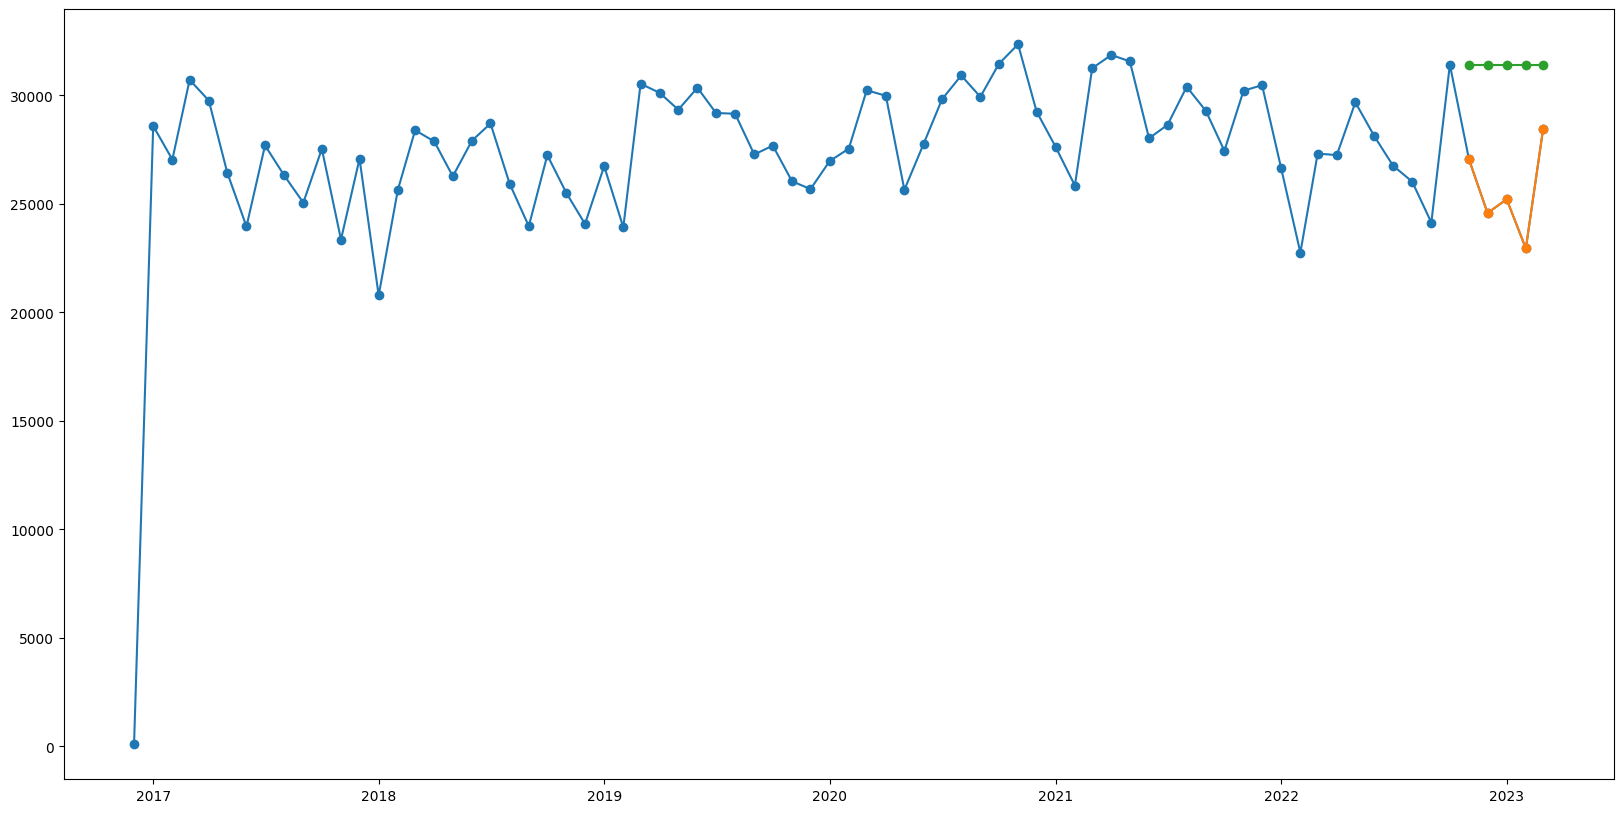

In [49]:
temp_data = find_value(grouped_extended, 1, 519, 79, 79)
temp_true = find_value(grouped_fact, 1, 519, 79, 79)
temp_forc = find_value(grouped_forecast, 1, 519, 79, 79)

plt.plot(temp_data['period'], temp_data['real_wagon_count'], marker='o', label='train_data')
plt.plot(temp_true['period'].astype("datetime64[ns]"), temp_true['real_wagon_count'], marker='o', label='real_data')
plt.plot(temp_forc['period'].astype("datetime64[ns]"), temp_forc['forecast_wagon_count'], marker='o', label='pred_data')

In [ ]:
sns.histplot(compare_table['ABS_ERR'])